In [43]:
!pip install torch

In [ ]:
# Настройки
plt.style.use('ggplot')
%matplotlib inline

In [62]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

class TumorDataset(Dataset):
    def __init__(self, metadata, jpeg_dir, masks_dir=None, img_size=(256, 256)):
        self.metadata = metadata
        self.jpeg_dir = jpeg_dir
        self.masks_dir = masks_dir
        self.img_size = img_size
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Загрузка изображения
        img_path = Path(row['image_path'])
        img = Image.open(img_path)
        img = img.convert('L')  # Конвертация в grayscale
        img = img.resize(self.img_size)
        img_array = np.array(img) / 255.0
        img_tensor = torch.from_numpy(img_array).float().unsqueeze(0)
        
        # Обработка маски
        mask_path = row.get('mask_path')
        if mask_path is not None and pd.notna(mask_path) and Path(mask_path).exists():
            mask = Image.open(mask_path)
            mask = mask.resize(self.img_size)
            mask_array = np.array(mask) > 0
        else:
            # Автоматическая сегментация, если нет маски
            mask_array = self._segment_tumor(np.array(img))
            
        mask_tensor = torch.from_numpy(mask_array).float().unsqueeze(0)
        
        return img_tensor, mask_tensor
    
    def _segment_tumor(self, image):
        """Автоматическая сегментация опухоли"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return binary > 0

class TumorTrainer:
    def __init__(self, base_dir="data"):
        self.base_dir = Path(base_dir)
        self.csv_dir = self.base_dir / "csv"
        self.jpeg_dir = self.base_dir / "jpeg"
        self.masks_dir = self.base_dir / "masks"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def _load_and_prepare_metadata(self, csv_file):
        """Загрузка и подготовка метаданных"""
        print(f"Загрузка метаданных из {csv_file}...")
        try:
            df = pd.read_csv(self.csv_dir / csv_file)
            
            # Поиск путей к изображениям
            df['image_path'] = df['image file path'].apply(
                lambda x: self._find_image_path(x))
            
            # Поиск путей к маскам (если есть)
            if 'cropped image file path' in df.columns:
                df['mask_path'] = df['cropped image file path'].apply(
                    lambda x: self._find_mask_path(x))
            
            df['has_image'] = df['image_path'].apply(
                lambda x: x is not None and os.path.exists(x))
            
            valid_df = df[df['has_image']].copy()
            print(f"Найдено {len(valid_df)} валидных примеров")
            return valid_df
            
        except Exception as e:
            print(f"Ошибка загрузки: {str(e)}")
            return pd.DataFrame()
    
    def _find_image_path(self, csv_path):
        """Находит путь к изображению по данным из CSV"""
        try:
            parts = csv_path.split('/')
            if len(parts) < 2:
                return None
                
            uid = parts[-2]  # Получаем UID из пути
            jpeg_file = next((self.jpeg_dir / uid).glob('*.jp*'), None)
            return str(jpeg_file) if jpeg_file else None
        except:
            return None
    
    def _find_mask_path(self, csv_path):
        """Находит путь к маске по данным из CSV"""
        try:
            if not self.masks_dir.exists():
                return None
                
            parts = csv_path.split('/')
            if len(parts) < 2:
                return None
                
            uid = parts[-2]
            mask_file = next((self.masks_dir / uid).glob('*.png'), None)
            return str(mask_file) if mask_file else None
        except:
            return None
    
    def load_datasets(self):
        """Загрузка тренировочного и тестового наборов"""
        train_df = self._load_and_prepare_metadata("mass_case_description_train_set.csv")
        test_df = self._load_and_prepare_metadata("mass_case_description_test_set.csv")
        
        if len(train_df) == 0 or len(test_df) == 0:
            raise ValueError("Недостаточно данных для обучения")
        
        train_dataset = TumorDataset(train_df, self.jpeg_dir, self.masks_dir)
        test_dataset = TumorDataset(test_df, self.jpeg_dir, self.masks_dir)
        
        return train_dataset, test_dataset
    
    def train(self, epochs=25, batch_size=8, lr=1e-4):
        """Процесс обучения модели"""
        train_dataset, val_dataset = self.load_datasets()
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        model = UNet().to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        best_val_loss = float('inf')
        history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            
            for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, masks = images.to(self.device), masks.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            # Валидация
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = model(images)
                    val_loss += criterion(outputs, masks).item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                print("Сохранена новая лучшая модель")
        
        # Визуализация процесса обучения
        plt.figure(figsize=(10, 5))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('График обучения')
        plt.show()
        
        return model

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder (upsampling)
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.conv_out = nn.Conv2d(64, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return torch.sigmoid(self.conv_out(dec1))


Загрузка метаданных из mass_case_description_train_set.csv...
Найдено 1318 валидных примеров
Загрузка метаданных из mass_case_description_test_set.csv...
Найдено 378 валидных примеров


Epoch 1/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2025 | Val Loss: 0.1488
Сохранена новая лучшая модель


Epoch 2/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.1293 | Val Loss: 0.1130
Сохранена новая лучшая модель


Epoch 3/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.0984 | Val Loss: 0.0826
Сохранена новая лучшая модель


Epoch 4/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.0768 | Val Loss: 0.0623
Сохранена новая лучшая модель


Epoch 5/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.0621 | Val Loss: 0.0622
Сохранена новая лучшая модель


Epoch 6/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.0547 | Val Loss: 0.0474
Сохранена новая лучшая модель


Epoch 7/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.0482 | Val Loss: 0.0397
Сохранена новая лучшая модель


Epoch 8/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.0441 | Val Loss: 0.0390
Сохранена новая лучшая модель


Epoch 9/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.0399 | Val Loss: 0.0351
Сохранена новая лучшая модель


Epoch 10/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.0369 | Val Loss: 0.0323
Сохранена новая лучшая модель


Epoch 11/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.0361 | Val Loss: 0.0356


Epoch 12/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.0337 | Val Loss: 0.0286
Сохранена новая лучшая модель


Epoch 13/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.0300 | Val Loss: 0.0310


Epoch 14/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.0290 | Val Loss: 0.0327


Epoch 15/15:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.0292 | Val Loss: 0.0281
Сохранена новая лучшая модель


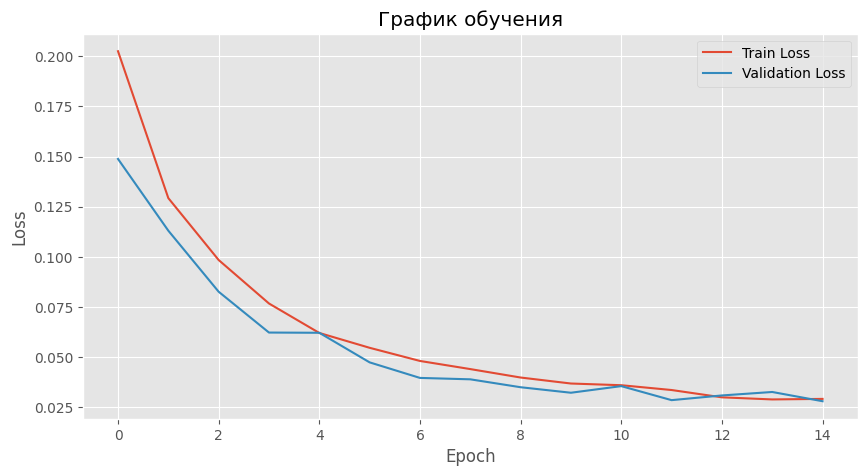

In [63]:
trainer = TumorTrainer(base_dir="data")
model = trainer.train(epochs=15, batch_size=8)